# Analysis of Improved Generated Articles

Analysis of the dataset generated with the improved pipeline (controlled omissions, model name diversity).

In [1]:
import json
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

OUTPUT_DIR = "output_improved"
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)
EXPECTED_TAGS = ["model", "params", "gpu_count", "hardware", "training", "country", "year"]
INFO_FIELDS = ["model_name", "parameter_count", "gpu_count", "hardware", "training_duration", "country", "year"]

## 1. Load Data

In [2]:
def load_all_articles():
    all_data = {}
    for model_name in sorted(os.listdir(OUTPUT_DIR)):
        model_dir = os.path.join(OUTPUT_DIR, model_name)
        json_path = os.path.join(model_dir, "articles.json")
        if os.path.exists(json_path):
            with open(json_path, "r", encoding="utf-8") as f:
                all_data[model_name] = json.load(f)
    return all_data

data = load_all_articles()

for model, articles in data.items():
    print(f"{model}: {len(articles)} articles")
total = sum(len(a) for a in data.values())
print(f"\nTotal: {total} articles")

claude-sonnet: 100 articles
gemini-2.5-flash: 100 articles
gemini-3-flash-preview: 88 articles
kimi: 99 articles
qwen: 92 articles

Total: 479 articles


## 2. Success Rate

In [3]:
NUM_EXPECTED = 100

success_data = []
for model_name, articles in data.items():
    success_data.append({
        "Model": model_name,
        "Generated": len(articles),
        "Expected": NUM_EXPECTED,
        "Success Rate": f"{(len(articles)/NUM_EXPECTED)*100:.0f}%"
    })

pd.DataFrame(success_data)

,Model,Generated,Expected,Success Rate
0,claude-sonnet,100,100,100%
1,gemini-2.5-flash,100,100,100%
2,gemini-3-flash-preview,88,100,88%
3,kimi,99,100,99%
4,qwen,92,100,92%


## 3. Omission Analysis

Distribution of omitted fields ("Not specified") per model.

In [4]:
omission_data = []

for model_name, articles in data.items():
    field_omitted = Counter()
    omission_counts = []

    for article in articles:
        info = article.get("information", {})
        n_omitted = 0
        for field in INFO_FIELDS:
            if info.get(field, "Not specified") == "Not specified":
                field_omitted[field] += 1
                n_omitted += 1
        omission_counts.append(n_omitted)

    total = len(articles)
    row = {"Model": model_name}
    for field in INFO_FIELDS:
        row[field] = f"{field_omitted[field]}/{total} ({field_omitted[field]/total*100:.0f}%)"
    row["Avg omissions/article"] = f"{sum(omission_counts)/len(omission_counts):.1f}"
    omission_data.append(row)

pd.DataFrame(omission_data)

,Model,model_name,parameter_count,gpu_count,hardware,training_duration,country,year,Avg omissions/article
0,claude-sonnet,41/100 (41%),37/100 (37%),38/100 (38%),35/100 (35%),37/100 (37%),29/100 (29%),38/100 (38%),2.5
1,gemini-2.5-flash,39/100 (39%),32/100 (32%),33/100 (33%),33/100 (33%),29/100 (29%),32/100 (32%),31/100 (31%),2.3
2,gemini-3-flash-preview,28/88 (32%),24/88 (27%),18/88 (20%),24/88 (27%),24/88 (27%),27/88 (31%),36/88 (41%),2.1
3,kimi,23/99 (23%),40/99 (40%),28/99 (28%),30/99 (30%),31/99 (31%),30/99 (30%),30/99 (30%),2.1
4,qwen,32/92 (35%),41/92 (45%),30/92 (33%),31/92 (34%),35/92 (38%),36/92 (39%),38/92 (41%),2.6


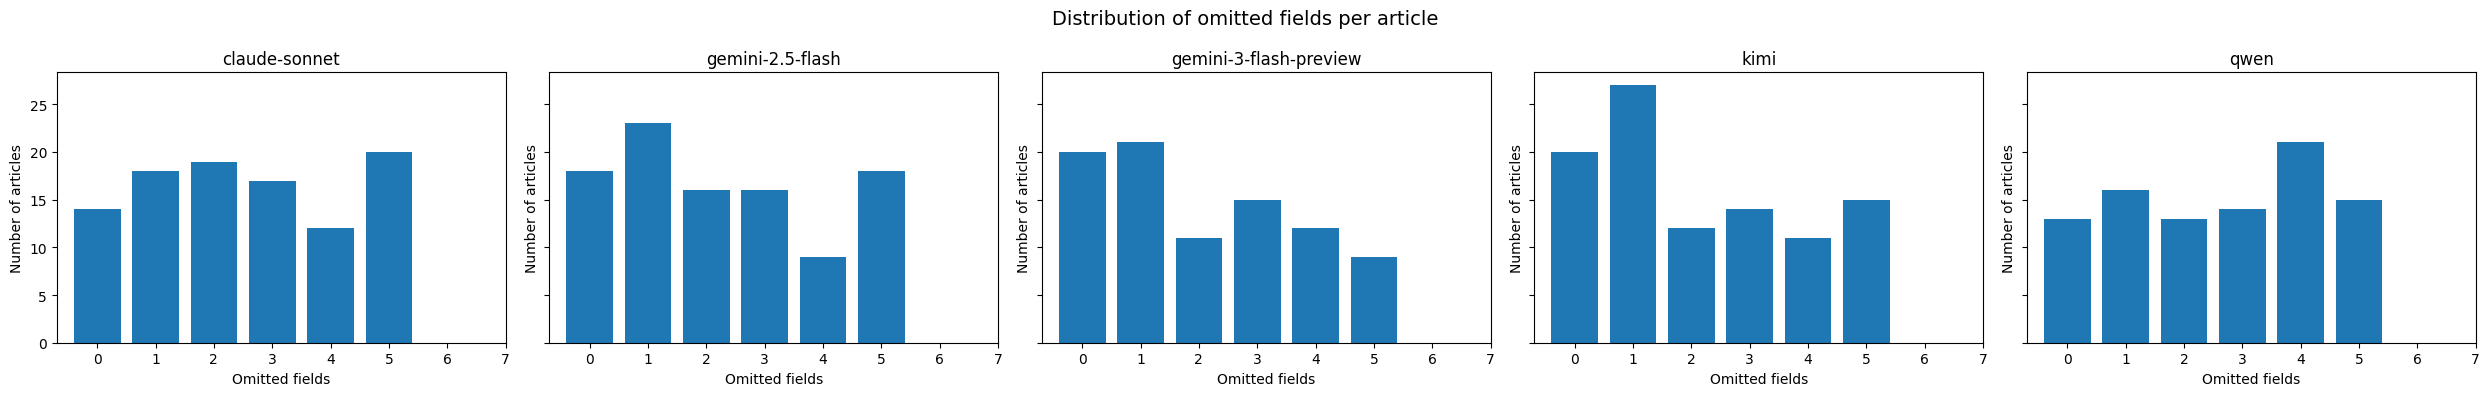

In [5]:
fig, axes = plt.subplots(1, len(data), figsize=(5*len(data), 4), sharey=True)
if len(data) == 1:
    axes = [axes]

for ax, (model_name, articles) in zip(axes, data.items()):
    omission_counts = []
    for article in articles:
        info = article.get("information", {})
        n = sum(1 for f in INFO_FIELDS if info.get(f, "Not specified") == "Not specified")
        omission_counts.append(n)

    counts = Counter(omission_counts)
    x = sorted(counts.keys())
    y = [counts[k] for k in x]
    ax.bar(x, y)
    ax.set_title(model_name)
    ax.set_xlabel("Omitted fields")
    ax.set_ylabel("Number of articles")
    ax.set_xticks(range(0, 8))

plt.suptitle("Distribution of omitted fields per article", fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "omission_distribution_per_model.png"), dpi=150, bbox_inches='tight')
plt.show()

## 4. XML Tags Compliance

In [6]:
def check_tags(text):
    found = {}
    for tag in EXPECTED_TAGS:
        pattern = f"<{tag}>.*?</{tag}>"
        found[tag] = bool(re.search(pattern, text, re.DOTALL))
    return found

tags_data = []

for model_name, articles in data.items():
    tag_counts = defaultdict(int)

    for article in articles:
        text = article.get("article", "")
        info = article.get("information", {})
        tags = check_tags(text)

        for tag in EXPECTED_TAGS:
            if tags[tag]:
                tag_counts[tag] += 1

    total = len(articles)
    row = {"Model": model_name}
    for tag in EXPECTED_TAGS:
        row[f"<{tag}>"] = f"{tag_counts[tag]}/{total}"
    tags_data.append(row)

pd.DataFrame(tags_data)

,Model,<model>,<params>,<gpu_count>,<hardware>,<training>,<country>,<year>
0,claude-sonnet,60/100,63/100,62/100,66/100,63/100,71/100,62/100
1,gemini-2.5-flash,61/100,68/100,67/100,67/100,71/100,68/100,69/100
2,gemini-3-flash-preview,60/88,64/88,70/88,64/88,64/88,61/88,52/88
3,kimi,78/99,56/99,71/99,69/99,69/99,67/99,69/99
4,qwen,71/92,55/92,65/92,63/92,63/92,62/92,56/92


## 5. Article Length

In [7]:
length_data = []

for model_name, articles in data.items():
    words = [len(a.get("article", "").split()) for a in articles]
    paras = [len([p for p in a.get("article", "").split('\n\n') if p.strip()]) for a in articles]

    length_data.append({
        "Model": model_name,
        "Words (min)": min(words),
        "Words (max)": max(words),
        "Words (avg)": f"{sum(words)/len(words):.0f}",
        "Paragraphs (avg)": f"{sum(paras)/len(paras):.1f}"
    })

pd.DataFrame(length_data)

,Model,Words (min),Words (max),Words (avg),Paragraphs (avg)
0,claude-sonnet,155,383,221,1.4
1,gemini-2.5-flash,156,381,285,3.1
2,gemini-3-flash-preview,142,327,236,2.4
3,kimi,96,248,159,1.0
4,qwen,1,185,135,1.0


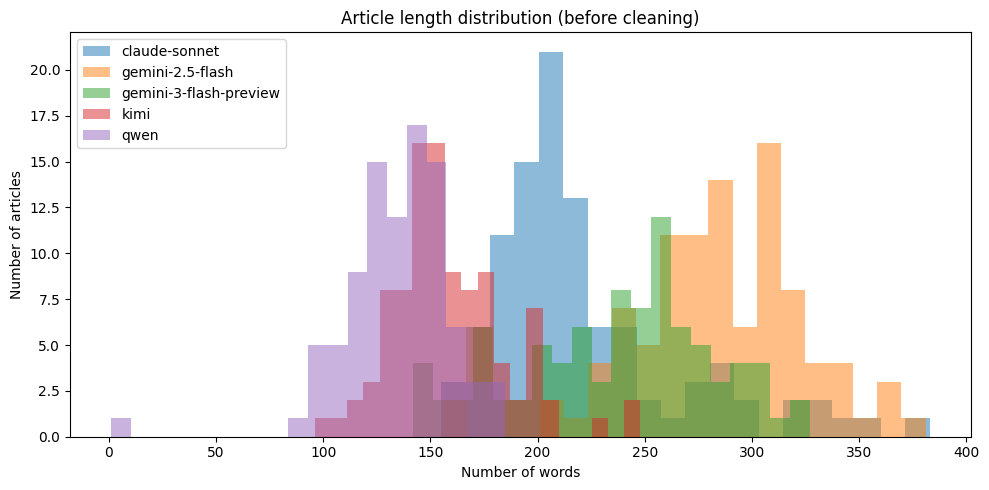

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

for model_name, articles in data.items():
    words = [len(a.get("article", "").split()) for a in articles]
    ax.hist(words, bins=20, alpha=0.5, label=model_name)

ax.set_xlabel("Number of words")
ax.set_ylabel("Number of articles")
ax.set_title("Article length distribution (before cleaning)")
ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "length_distribution_per_model.png"), dpi=150, bbox_inches='tight')
plt.show()

### 5.1 Cleaning (remove outliers)

In [9]:
for model_name in list(data.keys()):
    before = len(data[model_name])
    data[model_name] = [a for a in data[model_name] if len(a.get("article", "").split()) > 1]
    after = len(data[model_name])
    if before != after: 
        print(f"{model_name}: {before} -> {after} articles (removed {before - after} empty/short articles)")
print(f"\nTotal after cleaning: {sum(len(a) for a in data.values())} articles")

qwen: 92 -> 91 articles (removed 1 empty/short articles)

Total after cleaning: 478 articles


In [10]:
cleaned_articles = []
for model_name, articles in data.items():
    cleaned_articles.extend(articles)
with open("data/all_articles.json", "w", encoding="utf-8") as f:
    json.dump(cleaned_articles, f, ensure_ascii=False, indent=2)
print(f"Saved {len(cleaned_articles)} articles to data/all_articles.json")

Saved 478 articles to data/all_articles.json


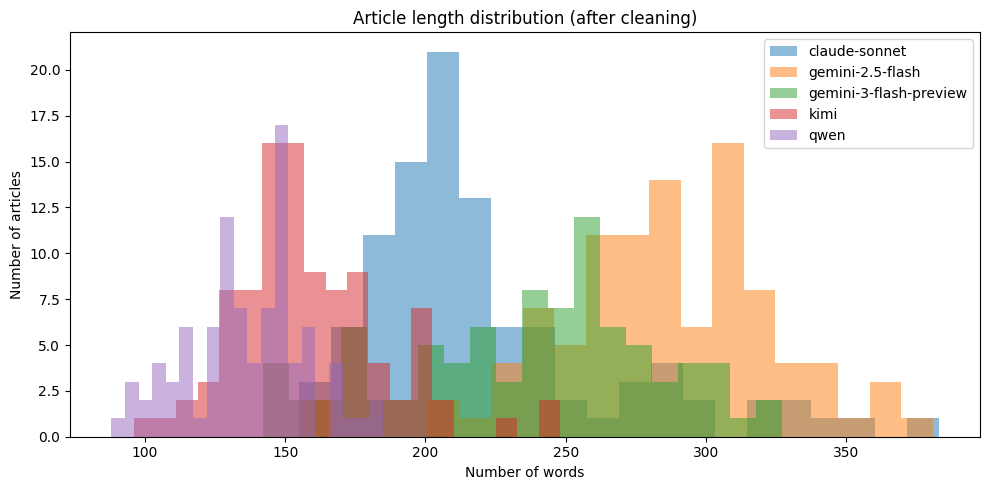

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

for model_name, articles in data.items():
    words = [len(a.get("article", "").split()) for a in articles]
    ax.hist(words, bins=20, alpha=0.5, label=model_name)

ax.set_xlabel("Number of words")
ax.set_ylabel("Number of articles")
ax.set_title("Article length distribution (after cleaning)")
ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "length_distribution_after_cleaning.png"), dpi=150, bbox_inches='tight')
plt.show()

## 6. Diversity Analysis

### 6.1 Unique Model Names

In [12]:
def extract_tag_value(text, tag):
    match = re.search(f"<{tag}>(.*?)</{tag}>", text, re.DOTALL)
    return match.group(1).strip() if match else None

for model_name, articles in data.items():
    names = []
    for a in articles:
        info = a.get("information", {})
        name = info.get("model_name", "Not specified")
        if name != "Not specified":
            names.append(name)

    unique = set(names)
    print(f"\n{model_name}: {len(unique)} unique / {len(names)} specified")
    duplicates = {n: c for n, c in Counter(names).items() if c > 1}
    if duplicates:
        print(f"  Duplicates: {duplicates}")


claude-sonnet: 59 unique / 59 specified

gemini-2.5-flash: 61 unique / 61 specified

gemini-3-flash-preview: 60 unique / 60 specified

kimi: 69 unique / 76 specified
  Duplicates: {'OpenAI-TritonFlow-9B': 2, 'UKP-PubMedBERT-110M': 3, 'Google-VideoPoet-18B': 2, 'NeuralMuse-9B': 2, 'BridgeNet-11B': 2, 'Gemini-Nano-1.8B': 2}

qwen: 59 unique / 60 specified
  Duplicates: {'MediSpeech-Transformer': 2}


### 6.2 Hardware Diversity

In [13]:
for model_name, articles in data.items():
    hw_list = []
    for a in articles:
        info = a.get("information", {})
        hw = info.get("hardware", "Not specified")
        if hw != "Not specified":
            hw_list.append(hw)

    print(f"\n{model_name}: {len(set(hw_list))} unique / {len(hw_list)} specified")
    print(f"  Top 5: {Counter(hw_list).most_common(5)}")


claude-sonnet: 9 unique / 65 specified
  Top 5: [('NVIDIA H100 GPUs', 26), ('NVIDIA A100 40GB GPUs', 13), ('NVIDIA A100 80GB GPUs', 6), ('NVIDIA H100 SXM5 GPUs', 6), ('NVIDIA H100 SXM GPUs', 5)]

gemini-2.5-flash: 5 unique / 67 specified
  Top 5: [('NVIDIA A100 80GB GPUs', 51), ('NVIDIA H100 GPUs', 8), ('TPU v4 chips', 5), ('NVIDIA H100 80GB GPUs', 2), ('TPU v5p chips', 1)]

gemini-3-flash-preview: 6 unique / 64 specified
  Top 5: [('NVIDIA H100 80GB GPUs', 27), ('NVIDIA H100 GPUs', 13), ('NVIDIA A100 80GB GPUs', 11), ('TPU v4 chips', 7), ('TPU v5p chips', 5)]

kimi: 13 unique / 69 specified
  Top 5: [('NVIDIA H100 80GB GPUs', 21), ('NVIDIA A100 40GB GPUs', 11), ('TPU v5e chips', 9), ('NVIDIA A100 80GB GPUs', 9), ('TPU v5p chips', 5)]

qwen: 5 unique / 60 specified
  Top 5: [('NVIDIA A100 80GB GPUs', 28), ('NVIDIA H100 GPUs', 12), ('NVIDIA H100 80GB GPUs', 10), ('NVIDIA A100 GPUs', 8), ('NVIDIA V100 GPUs', 2)]


### 6.3 Country Diversity

In [14]:
for model_name, articles in data.items():
    countries = []
    for a in articles:
        info = a.get("information", {})
        c = info.get("country", "Not specified")
        if c != "Not specified":
            countries.append(c)

    print(f"\n{model_name}: {len(set(countries))} unique / {len(countries)} specified")
    print(f"  Top 5: {Counter(countries).most_common(5)}")


claude-sonnet: 6 unique / 71 specified
  Top 5: [('Singapore', 51), ('United States', 6), ('Canada', 5), ('Switzerland', 5), ('France', 2)]

gemini-2.5-flash: 9 unique / 68 specified
  Top 5: [('France', 20), ('Singapore', 13), ('United States', 13), ('China', 6), ('South Korea', 4)]

gemini-3-flash-preview: 6 unique / 61 specified
  Top 5: [('Singapore', 38), ('United States', 9), ('France', 5), ('China', 5), ('United Kingdom', 3)]

kimi: 11 unique / 69 specified
  Top 5: [('United States', 19), ('France', 16), ('Canada', 10), ('Singapore', 6), ('China', 6)]

qwen: 4 unique / 55 specified
  Top 5: [('United Kingdom', 30), ('United States', 12), ('Canada', 7), ('Germany', 6)]


### 6.4 Year Distribution

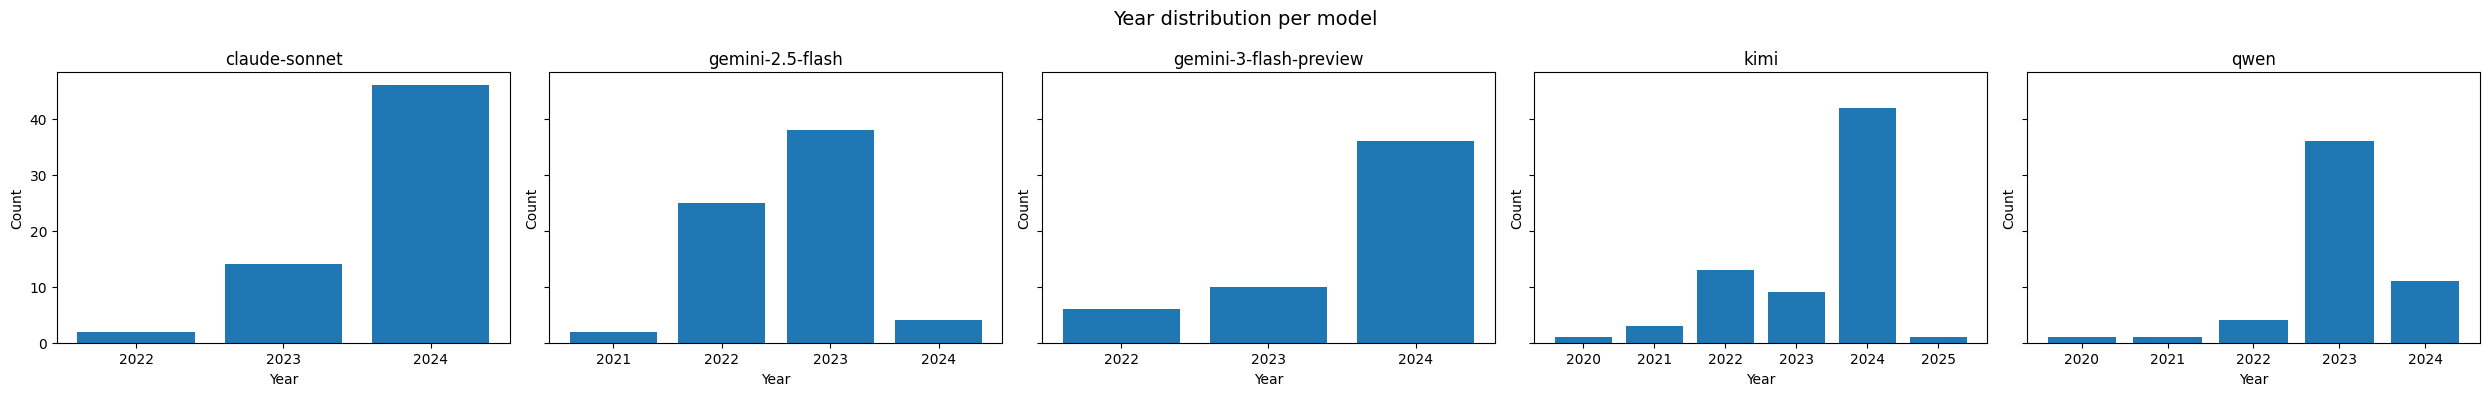

In [15]:
fig, axes = plt.subplots(1, len(data), figsize=(5*len(data), 4), sharey=True)
if len(data) == 1:
    axes = [axes]

for ax, (model_name, articles) in zip(axes, data.items()):
    years = []
    for a in articles:
        info = a.get("information", {})
        y = info.get("year", "Not specified")
        if y != "Not specified":
            years.append(str(y))

    counts = Counter(years)
    x = sorted(counts.keys())
    y = [counts[k] for k in x]
    ax.bar(x, y)
    ax.set_title(model_name)
    ax.set_xlabel("Year")
    ax.set_ylabel("Count")

plt.suptitle("Year distribution per model", fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "year_distribution_per_model.png"), dpi=150, bbox_inches='tight')
plt.show()

### 6.5 Opening Bigram & Trigram per model

## 7. Summary Table

In [16]:
summary_data = []

for model_name, articles in data.items():
    total = len(articles)
    model_names = set()
    hardware = set()
    countries = set()
    years = set()
    omission_counts = []

    for article in articles:
        info = article.get("information", {})

        m = info.get("model_name", "Not specified")
        if m != "Not specified": model_names.add(m)

        h = info.get("hardware", "Not specified")
        if h != "Not specified": hardware.add(h)

        c = info.get("country", "Not specified")
        if c != "Not specified": countries.add(c)

        y = info.get("year", "Not specified")
        if y != "Not specified": years.add(str(y))

        n = sum(1 for f in INFO_FIELDS if info.get(f, "Not specified") == "Not specified")
        omission_counts.append(n)

    summary_data.append({
        "Model": model_name,
        "Articles": total,
        "Unique Models": len(model_names),
        "Unique Hardware": len(hardware),
        "Unique Countries": len(countries),
        "Unique Years": len(years),
        "Avg Omissions": f"{sum(omission_counts)/len(omission_counts):.1f}"
    })

pd.DataFrame(summary_data)

,Model,Articles,Unique Models,Unique Hardware,Unique Countries,Unique Years,Avg Omissions
0,claude-sonnet,100,59,9,6,3,2.5
1,gemini-2.5-flash,100,61,5,9,4,2.3
2,gemini-3-flash-preview,88,60,6,6,3,2.1
3,kimi,99,69,13,11,6,2.1
4,qwen,91,59,5,4,5,2.6


In [17]:
def clean_start(text):
    cleaned = re.sub(r'<[^>]+>', '', text).strip()
    return cleaned.split()

for model_name, articles in data.items():
    bigrams = []
    trigrams = []

    for a in articles:
        words = clean_start(a.get("article", ""))
        if len(words) >= 2:
            bigrams.append(" ".join(words[:2]))
        if len(words) >= 3:
            trigrams.append(" ".join(words[:3]))

    print(f"\n{'='*50}")
    print(f"{model_name}")
    print(f"{'='*50}")
    print(f"\n  Top 10 Bigrams ({len(set(bigrams))} unique / {len(bigrams)} total):")
    for bg, count in Counter(bigrams).most_common(10):
        print(f"    {count:3d}x  \"{bg}\"")

    print(f"\n  Top 10 Trigrams ({len(set(trigrams))} unique / {len(trigrams)} total):")
    for tg, count in Counter(trigrams).most_common(10):
        print(f"    {count:3d}x  \"{tg}\"")


claude-sonnet

  Top 10 Bigrams (26 unique / 100 total):
     16x  "The training"
     16x  "We developed"
     13x  "Our implementation"
      7x  "The model"
      6x  "We implemented"
      6x  "Our training"
      5x  "Our experimental"
      4x  "Our multimodal"
      3x  "We implement"
      3x  "We evaluate"

  Top 10 Trigrams (63 unique / 100 total):
     12x  "The training infrastructure"
      7x  "The model architecture"
      5x  "Our experimental setup"
      4x  "Our implementation leverages"
      4x  "Our implementation is"
      3x  "Our multimodal architecture,"
      3x  "Our training infrastructure"
      2x  "The experimental setup"
      2x  "We evaluate the"
      2x  "Our implementation of"

gemini-2.5-flash

  Top 10 Bigrams (26 unique / 100 total):
     34x  "The core"
     20x  "Our proposed"
     10x  "The foundational"
      4x  "The proposed"
      4x  "Our primary"
      3x  "Our multimodal"
      3x  "Our foundational"
      3x  "Our experimental"
     

## 8. Global Analysis (after merge)

In [18]:
with open("data/all_articles.json", "r", encoding="utf-8") as f:
    all_articles = json.load(f)

print(f"Total dataset: {len(all_articles)} articles")

Total dataset: 478 articles


### 8.1 Global length distribution

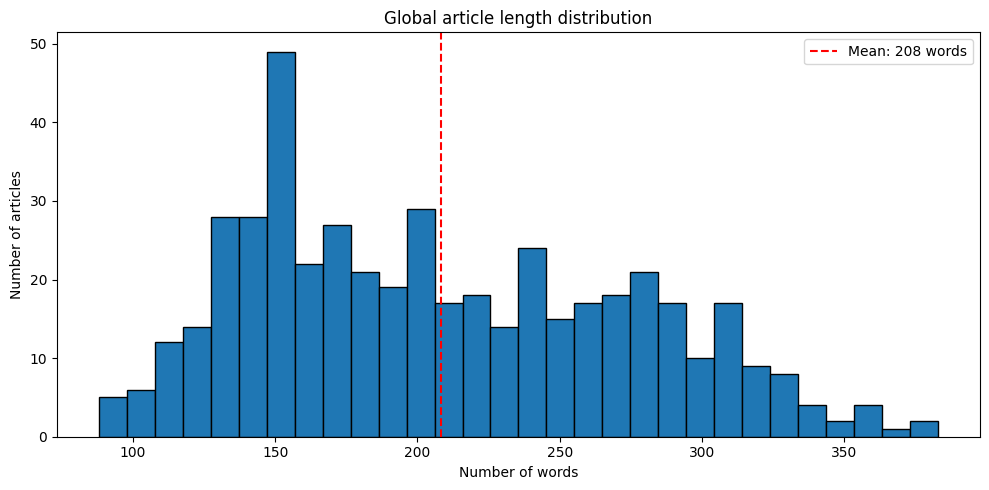

Min: 88 | Max: 383 | Mean: 208 | Median: 201


In [19]:
words_all = [len(a.get("article", "").split()) for a in all_articles]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(words_all, bins=30, edgecolor='black')
ax.axvline(sum(words_all)/len(words_all), color='red', linestyle='--', label=f"Mean: {sum(words_all)/len(words_all):.0f} words")
ax.set_xlabel("Number of words")
ax.set_ylabel("Number of articles")
ax.set_title("Global article length distribution")
ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "global_length_distribution.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"Min: {min(words_all)} | Max: {max(words_all)} | Mean: {sum(words_all)/len(words_all):.0f} | Median: {sorted(words_all)[len(words_all)//2]}")

### 8.2 Global omission analysis

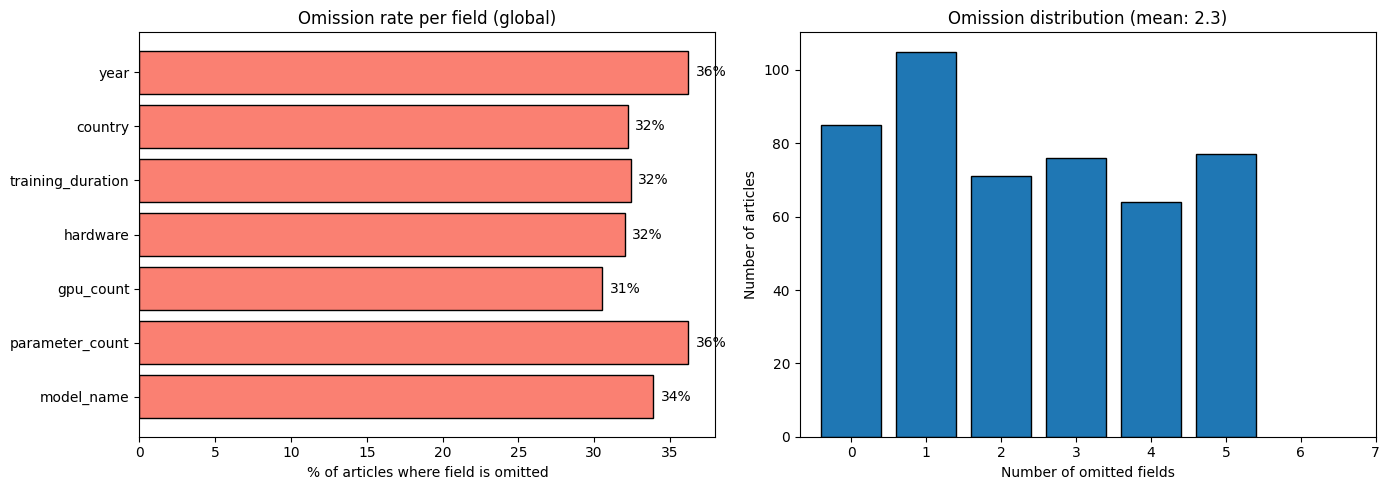

In [20]:
field_omitted = Counter()
omission_counts = []

for a in all_articles:
    info = a.get("information", {})
    n = 0
    for field in INFO_FIELDS:
        if info.get(field, "Not specified") == "Not specified":
            field_omitted[field] += 1
            n += 1
    omission_counts.append(n)

total = len(all_articles)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Omission rate per field
fields = INFO_FIELDS
rates = [field_omitted[f] / total * 100 for f in fields]
axes[0].barh(fields, rates, color='salmon', edgecolor='black')
axes[0].set_xlabel("% of articles where field is omitted")
axes[0].set_title("Omission rate per field (global)")
for i, v in enumerate(rates):
    axes[0].text(v + 0.5, i, f"{v:.0f}%", va='center')

# Distribution of number of omissions
counts = Counter(omission_counts)
x = sorted(counts.keys())
y = [counts[k] for k in x]
axes[1].bar(x, y, edgecolor='black')
axes[1].set_xlabel("Number of omitted fields")
axes[1].set_ylabel("Number of articles")
axes[1].set_title(f"Omission distribution (mean: {sum(omission_counts)/len(omission_counts):.1f})")
axes[1].set_xticks(range(0, 8))

plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "global_omission_analysis.png"), dpi=150, bbox_inches='tight')
plt.show()

### 8.3 Global diversity

In [21]:
all_model_names = [a["information"].get("model_name", "Not specified") for a in all_articles if a["information"].get("model_name", "Not specified") != "Not specified"]
all_hardware = [a["information"].get("hardware", "Not specified") for a in all_articles if a["information"].get("hardware", "Not specified") != "Not specified"]
all_countries = [a["information"].get("country", "Not specified") for a in all_articles if a["information"].get("country", "Not specified") != "Not specified"]
all_years = [str(a["information"].get("year", "Not specified")) for a in all_articles if a["information"].get("year", "Not specified") != "Not specified"]

print(f"Model names : {len(set(all_model_names))} unique / {len(all_model_names)} specified")
print(f"Hardware    : {len(set(all_hardware))} unique / {len(all_hardware)} specified")
print(f"Countries   : {len(set(all_countries))} unique / {len(all_countries)} specified")
print(f"Years       : {len(set(all_years))} unique / {len(all_years)} specified")

Model names : 301 unique / 316 specified
Hardware    : 21 unique / 325 specified
Countries   : 14 unique / 324 specified
Years       : 6 unique / 305 specified


### 8.4 Top 10 hardware, countries, years

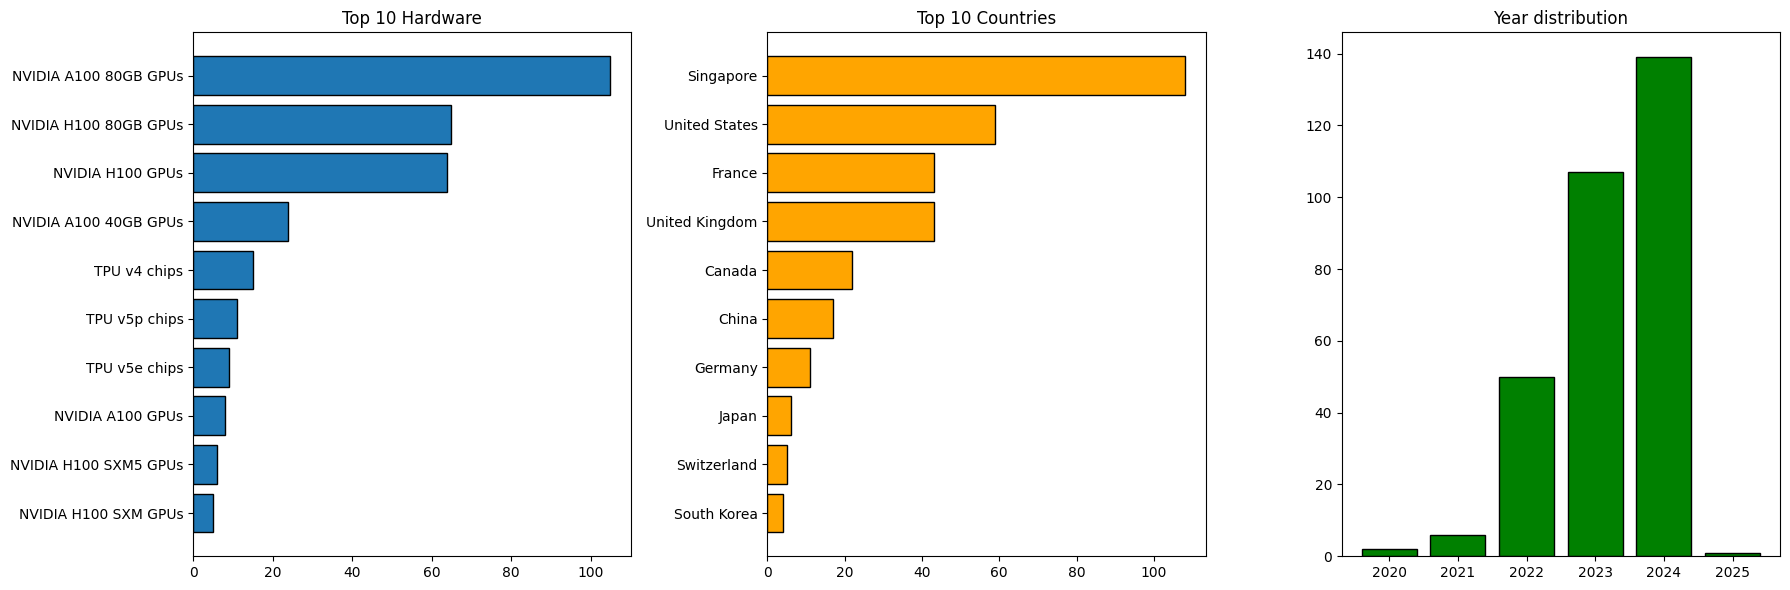

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Hardware
hw_counts = Counter(all_hardware).most_common(10)
axes[0].barh([h[0] for h in hw_counts][::-1], [h[1] for h in hw_counts][::-1], edgecolor='black')
axes[0].set_title("Top 10 Hardware")

# Countries
country_counts = Counter(all_countries).most_common(10)
axes[1].barh([c[0] for c in country_counts][::-1], [c[1] for c in country_counts][::-1], edgecolor='black', color='orange')
axes[1].set_title("Top 10 Countries")

# Years
year_counts = Counter(all_years)
years_sorted = sorted(year_counts.keys())
axes[2].bar(years_sorted, [year_counts[y] for y in years_sorted], edgecolor='black', color='green')
axes[2].set_title("Year distribution")

plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "global_top10_hardware_countries_years.png"), dpi=150, bbox_inches='tight')
plt.show()

### 8.5 Global XML tag compliance

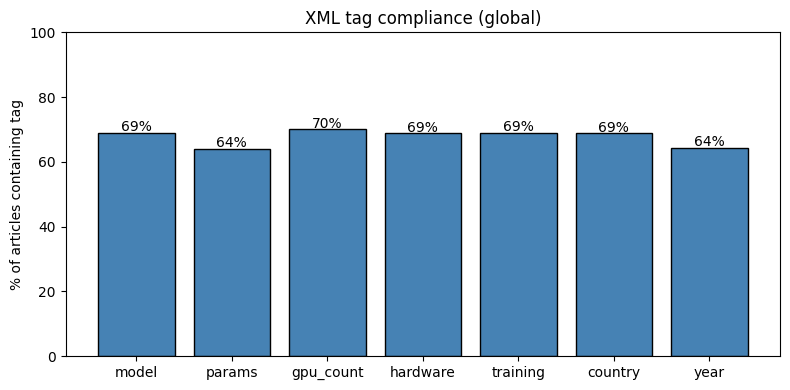

In [23]:
tag_counts = {tag: 0 for tag in EXPECTED_TAGS}
for a in all_articles:
    text = a.get("article", "")
    for tag in EXPECTED_TAGS:
        if re.search(f"<{tag}>.*?</{tag}>", text, re.DOTALL):
            tag_counts[tag] += 1

total = len(all_articles)
fig, ax = plt.subplots(figsize=(8, 4))
tags = list(tag_counts.keys())
vals = [tag_counts[t] / total * 100 for t in tags]
ax.bar(tags, vals, edgecolor='black', color='steelblue')
ax.set_ylabel("% of articles containing tag")
ax.set_title("XML tag compliance (global)")
for i, v in enumerate(vals):
    ax.text(i, v + 0.5, f"{v:.0f}%", ha='center')
ax.set_ylim(0, 100)
plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "global_xml_tag_compliance.png"), dpi=150, bbox_inches='tight')
plt.show()

### 8.6 Global opening bigram & trigram analysis

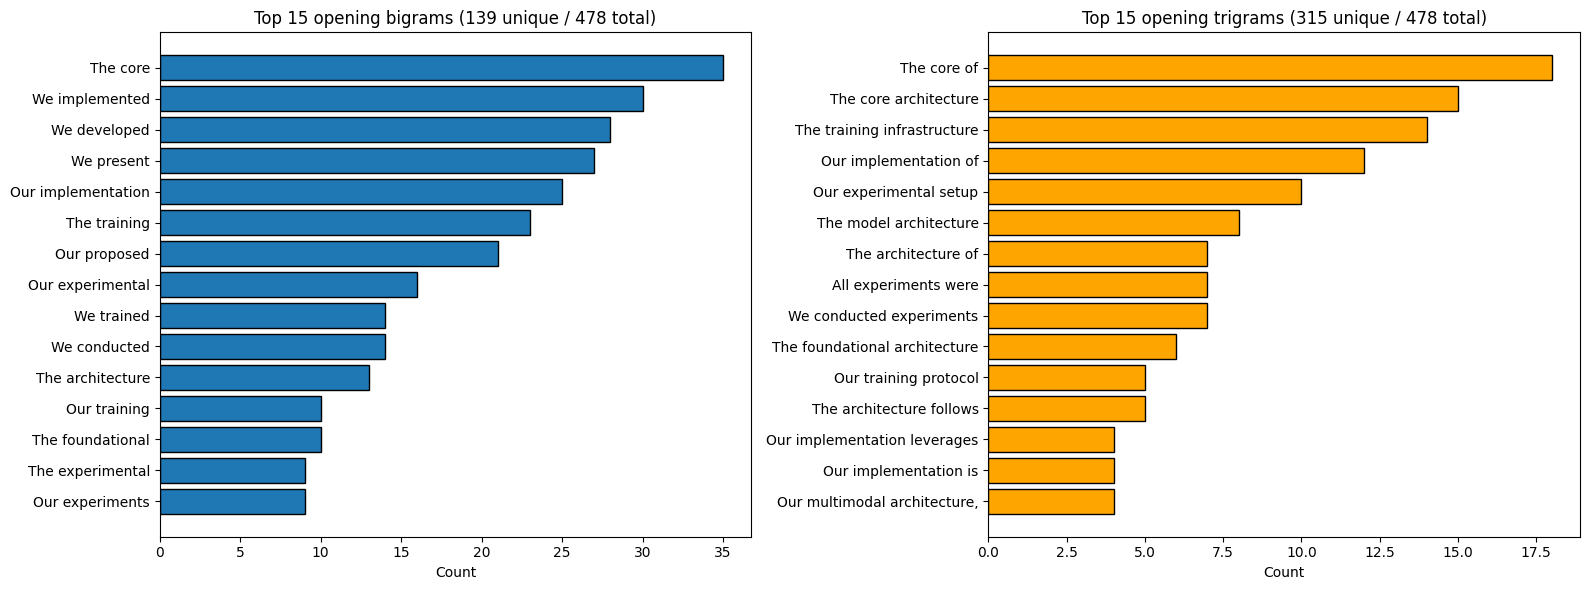

In [24]:
all_texts = [a.get("article", "") for a in all_articles]

def clean_start(text):
    cleaned = re.sub(r'<[^>]+>', '', text).strip()
    return cleaned.split()

bigrams = []
trigrams = []
for text in all_texts:
    words = clean_start(text)
    if len(words) >= 2:
        bigrams.append(" ".join(words[:2]))
    if len(words) >= 3:
        trigrams.append(" ".join(words[:3]))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bigrams
bg_counts = Counter(bigrams).most_common(15)
axes[0].barh([b[0] for b in bg_counts][::-1], [b[1] for b in bg_counts][::-1], edgecolor='black')
axes[0].set_title(f"Top 15 opening bigrams ({len(set(bigrams))} unique / {len(bigrams)} total)")
axes[0].set_xlabel("Count")

# Trigrams
tg_counts = Counter(trigrams).most_common(15)
axes[1].barh([t[0] for t in tg_counts][::-1], [t[1] for t in tg_counts][::-1], edgecolor='black', color='orange')
axes[1].set_title(f"Top 15 opening trigrams ({len(set(trigrams))} unique / {len(trigrams)} total)")
axes[1].set_xlabel("Count")

plt.tight_layout()
fig.savefig(os.path.join(PLOTS_DIR, "global_opening_bigrams_trigrams.png"), dpi=150, bbox_inches='tight')
plt.show()